In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn import tree 
import xgboost as xgb_package
import seaborn as sns

In [2]:
#reading files
training = pd.read_csv("training.csv", sep= ";", encoding='cp1252')

In [3]:
#titles list
titles = list(training.head())

IDP_bio = titles[4:7]
target_bio = titles[11:15]
biomarkerness = titles[62:65]

CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]

print(IDP_bio, target_bio, biomarkerness)
print(CSN, SIGNOR, ReactomeFI)

['neighbour disorder content', 'neighbour preclinical target', 'neighbour MCG target'] ['target of small molecule', 'target of antibody', 'targetneighbour', 'target disorder content'] ['prognostic', 'predisposing', 'diagnostic']
['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN'] ['neighbour in SIGNOR', 'target in SIGNOR', 'both in SIGNOR', 'in  triangle - SIGNOR', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR

In [4]:
#what to drop
to_drop = ["neighbour code", "target code", "predictive"]
only_topo = to_drop + IDP_bio + target_bio + biomarkerness
only_CSN = only_topo + SIGNOR + ReactomeFI
only_SIGNOR = only_topo + CSN + ReactomeFI 
only_ReactomeFI = only_topo + CSN + SIGNOR

In [5]:
#classifiers
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.5,
                                scale_pos_weight= 0.75,
                                reg_lambda= 0.25,
                                reg_alpha= 0.5,
                                min_child_weight= 0.75,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 0,
                                max_bin= 38,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0,
                                criterion= 'log_loss',
                                booster= 'dart')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False,
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0,
                             min_samples_split= 4,
                             min_samples_leaf= 3,
                             max_samples= 61,
                             max_leaf_nodes= 27,
                             max_features= None,
                             max_depth= 5,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)
svm = NuSVC(max_iter= 1000, random_state=42)

In [6]:
#data preparation
def prepare_data(drop_train, drop_test, training=training, test=training):
    """
    This function prepares the training and test data for the machine learning.
    Drops the previously selected columns using the drop_test list and renames the remaining columns.
    Splits the data to input parameters and labels.

    Args:
        drop_train: The list of column names which are going to be dropped from the training dataframe.
        drop_test: The list of column names which are going to be dropped from the test dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.
        test: The dataframe of input parameters which are intended to use to the testing of the machine learning model.

    Returns:
        X_train: The input data from the training dataframe.
        X_test: The input data from the test dataframe.
        y_train: The labels from the training dataframe.
        y_test: The labels from the test dataframe.

    """
    training_deleted = training.drop(columns= drop_train)
    training_deleted.columns = ['IDP in network',
                                 'target in network',
                                 'both in network',
                                 'both in all 3',
                                 'in triangle',
                                 'not in any triangle',
                                 'no. of triangles',
                                 'no. of in cycle',
                                 'no. of in unbalanced triangle',
                                 'IDP � target inhibition',
                                 'target � IDP stimulation',
                                 'IDP � target stimulation',
                                 'target � IDP inhibition',
                                 'IDP third partner',
                                 'target third partner',
                                 'IDP bridgeness',
                                 'IDP betweenness',
                                 'target bridgeness',
                                 'target betweenness',
                                 'predictive biomarker for target?']
    X_train = training_deleted.iloc[:,:-1]
    y_train = training_deleted.iloc[:, -1]
    test_deleted = test.drop(columns= drop_test)
    test_deleted.columns = ['IDP in network',
                                 'target in network',
                                 'both in network',
                                 'both in all 3',
                                 'in triangle',
                                 'not in any triangle',
                                 'no. of triangles',
                                 'no. of in cycle',
                                 'no. of in unbalanced triangle',
                                 'IDP � target inhibition',
                                 'target � IDP stimulation',
                                 'IDP � target stimulation',
                                 'target � IDP inhibition',
                                 'IDP third partner',
                                 'target third partner',
                                 'IDP bridgeness',
                                 'IDP betweenness',
                                 'target bridgeness',
                                 'target betweenness',
                                 'predictive biomarker for target?']
    X_test = test_deleted.iloc[:,:-1]
    y_test = test_deleted.iloc[:, -1]
    return X_train, X_test, y_train, y_test

In [7]:
#teaching - ROC/PR curve, scores
def teach_print_test_all(X_train, X_test, y_train, y_test, classifier, what):
    """
    This function teaches and tests the selected machine learning models while also calculating different metrics.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Calculates and returns accuracy, F1 score and ROC AUC.
    Based on selection, draws the ROC or PR curve.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        what: The selected graph drawn based on the performance of the classificator. Options: "ROC" or "PR".

    Returns:
        classifier_pred_train: Predictions on the training dataset.
        classifier_pred_test: Predictions on the test dataset.
        display: The display of the choosen graph.
        params: The list of the calculated metrics, such as accuracy, FR score, ROC AUC.

    """
    #fitting the scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
        
    #teaching
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)
    classifier_pred_test = classifier.predict(X_test)
    
    #accuracy+f1+auc
    acc = accuracy_score(y_test, classifier_pred_test)
    f1 = f1_score(y_test, classifier_pred_test)
    test_auc = roc_auc_score(y_test, classifier_pred_test)
    params= [acc, f1, test_auc]
    print(f"Accuracy: {acc}\n F1 score: {f1}\n Test AUC: {test_auc}")  
    print(params)    
    
    #test ROC curve
    if what == "ROC":
        ax1 = plt.gca()
        display = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax1, alpha=0.8)
        #plt.show()
    
    #precision recall
    elif what == "PR":
        ax2 = plt.gca()
        display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test, ax=ax2, alpha=0.8)
        #plt.show() 
        
    else: 
        print("Please give a valid option.")
    
    return classifier_pred_train, classifier_pred_test, display, params

In [8]:
def params_heatmap(params_xgb, params_rfc):
    """
    This function draws heatmap based on the performance metrics of the XGBoost and Random Forest algorhythms.
    Puts the input parameters into a dictionary, then into a dataframe.
    Transposes the dataframe to make the heatmap more easily understandable.
    Sets the name of the columns based on the name of the parameters: "Accuracy", "F1-score", "Test AUC score".
    Draws the heatmap.
    Returms the dataframe of the parameters.

    Args:
        params_xgb: Accuracy, F1-score, test AUC score for the XGBoost algorhythm.
        params_rfc: Accuracy, F1-score, test AUC score for the Random Forest algorhythm.

    Returns:
        params: Dataframe of the XGBoost and Random forest parameters.

    """
    params_dict = {'XGBoost': params_xgb, 'Random forest': params_rfc}
    print(dict)
    params = pd.DataFrame(params_dict)
    params = params.transpose()
    params = params.set_axis(["Accuracy", "F1-score", "Test AUC score"], axis=1)
    sns.heatmap(params, annot=True)
    print(params)
    return params

XGBoost results:
[06:40:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7155963302752294
 F1 score: 0.7801418439716312
 Test AUC: 0.6961016949152542
[0.7155963302752294, 0.7801418439716312, 0.6961016949152542]
Random forest results:
Accuracy: 0.6880733944954128
 F1 score: 0.7671232876712328
 Test AUC: 0.6645762711864407
[0.6880733944954128, 0.7671232876712328, 0.6645762711864407]


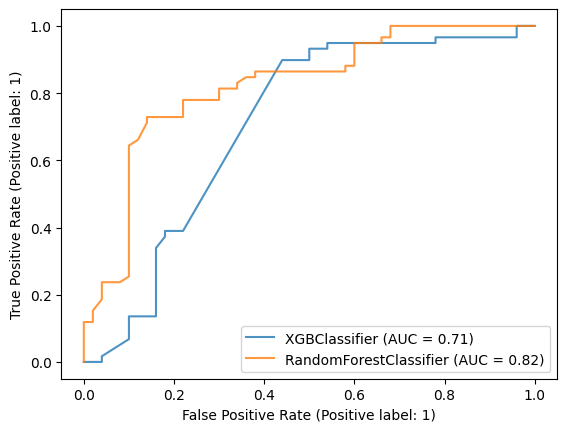

XGBoost results:
[06:40:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7155963302752294
 F1 score: 0.7801418439716312
 Test AUC: 0.6961016949152542
[0.7155963302752294, 0.7801418439716312, 0.6961016949152542]
Random forest results:
Accuracy: 0.6880733944954128
 F1 score: 0.7671232876712328
 Test AUC: 0.6645762711864407
[0.6880733944954128, 0.7671232876712328, 0.6645762711864407]


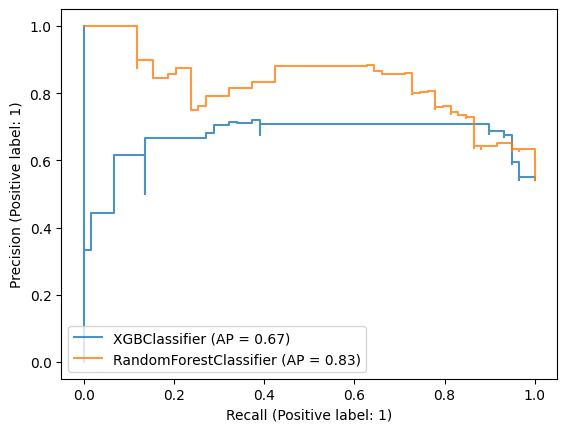

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.715596  0.780142        0.696102
Random forest  0.688073  0.767123        0.664576


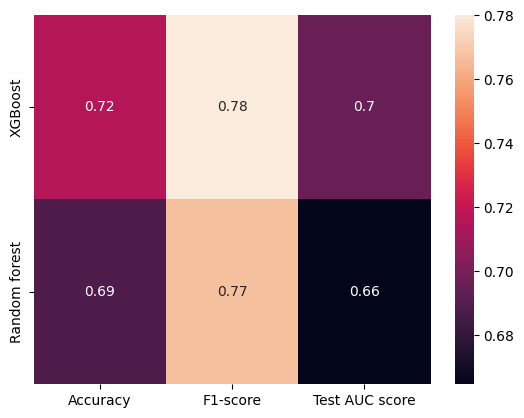

In [9]:
#CSN-SIGNOR
#ROC
X_train_CSN, X_test_SIGNOR, y_train_CSN, y_test_SIGNOR = prepare_data(drop_train=only_CSN, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                       y_train_CSN, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#heatmap
params_df_CSN_SIGNOR = params_heatmap(params_xgb=params_xgb_CSN_SIGNOR, params_rfc=params_rfc_CSN_SIGNOR)

XGBoost results:
[06:41:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7339449541284404
 F1 score: 0.7010309278350517
 Test AUC: 0.748135593220339
[0.7339449541284404, 0.7010309278350517, 0.748135593220339]
Random forest results:
Accuracy: 0.6513761467889908
 F1 score: 0.525
 Test AUC: 0.6779661016949152
[0.6513761467889908, 0.525, 0.6779661016949152]


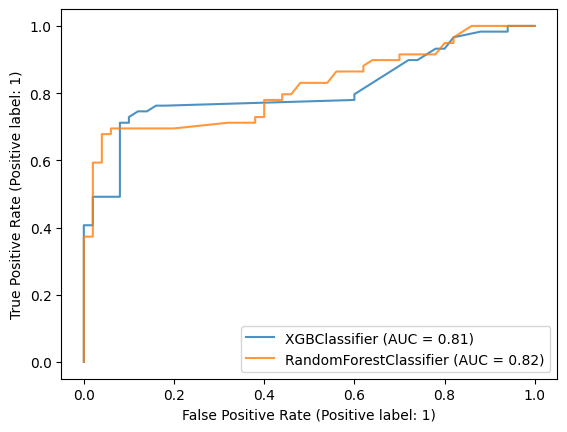

XGBoost results:
[06:41:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7339449541284404
 F1 score: 0.7010309278350517
 Test AUC: 0.748135593220339
[0.7339449541284404, 0.7010309278350517, 0.748135593220339]
Random forest results:
Accuracy: 0.6513761467889908
 F1 score: 0.525
 Test AUC: 0.6779661016949152
[0.6513761467889908, 0.525, 0.6779661016949152]


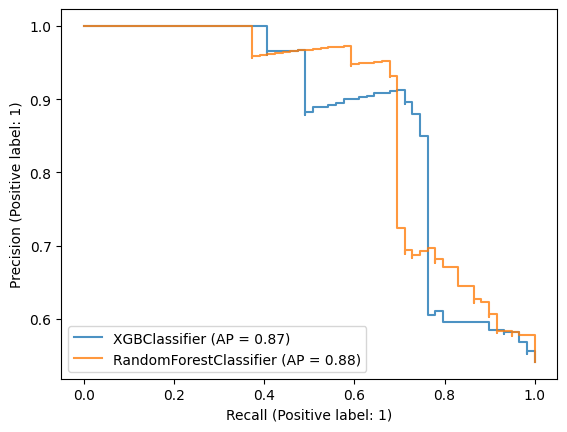

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.733945  0.701031        0.748136
Random forest  0.651376  0.525000        0.677966


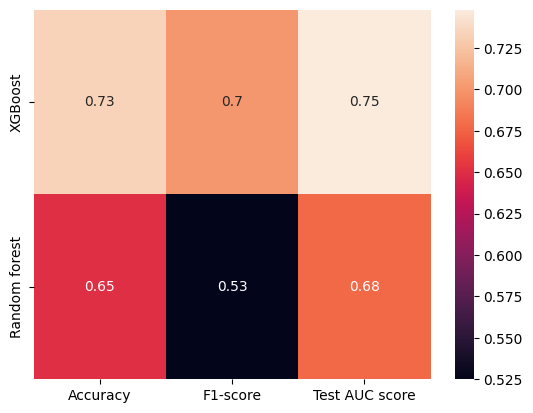

In [10]:
#SIGNOR_CSN
#ROC
X_train_SIGNOR, X_test_CSN, y_train_SIGNOR, y_test_CSN = prepare_data(drop_train=only_SIGNOR, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                       y_train_SIGNOR, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#heatmap
params_df_SIGNOR_CSN = params_heatmap(params_xgb=params_xgb_SIGNOR_CSN, params_rfc=params_rfc_SIGNOR_CSN)

XGBoost results:
[06:41:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6788990825688074
 F1 score: 0.7107438016528926
 Test AUC: 0.6744067796610169
[0.6788990825688074, 0.7107438016528926, 0.6744067796610169]
Random forest results:
Accuracy: 0.7155963302752294
 F1 score: 0.7703703703703703
 Test AUC: 0.7006779661016949
[0.7155963302752294, 0.7703703703703703, 0.7006779661016949]


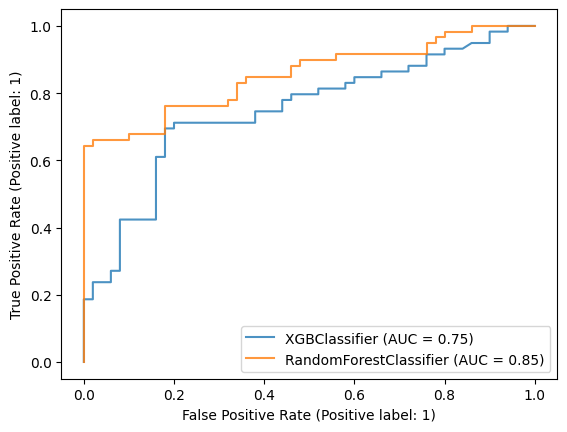

XGBoost results:
[06:41:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6788990825688074
 F1 score: 0.7107438016528926
 Test AUC: 0.6744067796610169
[0.6788990825688074, 0.7107438016528926, 0.6744067796610169]
Random forest results:
Accuracy: 0.7155963302752294
 F1 score: 0.7703703703703703
 Test AUC: 0.7006779661016949
[0.7155963302752294, 0.7703703703703703, 0.7006779661016949]


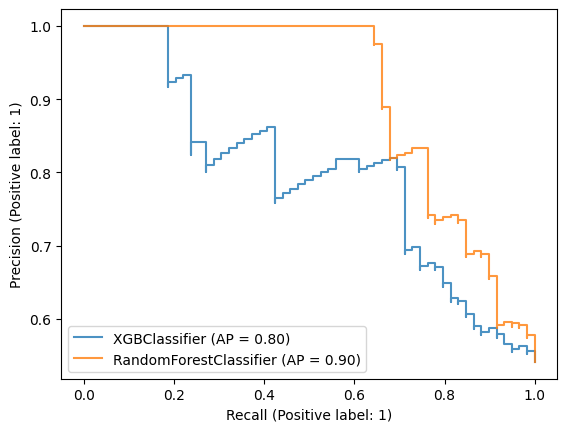

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.678899  0.710744        0.674407
Random forest  0.715596  0.770370        0.700678


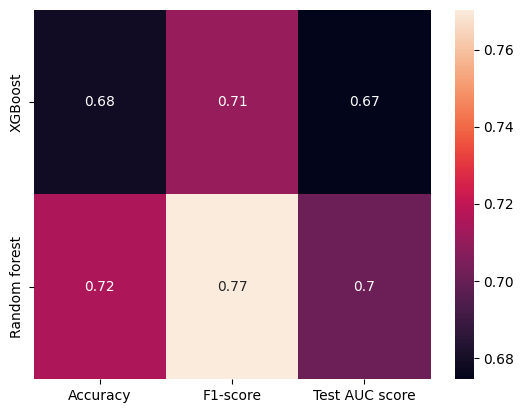

In [11]:
#SIGNOR_ReactomeFI
#ROC
X_train_SIGNOR, X_test_ReactomeFI, y_train_SIGNOR, y_test_ReactomeFI = prepare_data(drop_train=only_SIGNOR, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                       y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#heatmap
params_df_SIGNOR_ReactomeFI = params_heatmap(params_xgb=params_xgb_SIGNOR_ReactomeFI, params_rfc=params_rfc_SIGNOR_ReactomeFI)

XGBoost results:
[06:41:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7706422018348624
 F1 score: 0.7899159663865546
 Test AUC: 0.7683050847457628
[0.7706422018348624, 0.7899159663865546, 0.7683050847457628]
Random forest results:
Accuracy: 0.7339449541284404
 F1 score: 0.7010309278350517
 Test AUC: 0.748135593220339
[0.7339449541284404, 0.7010309278350517, 0.748135593220339]


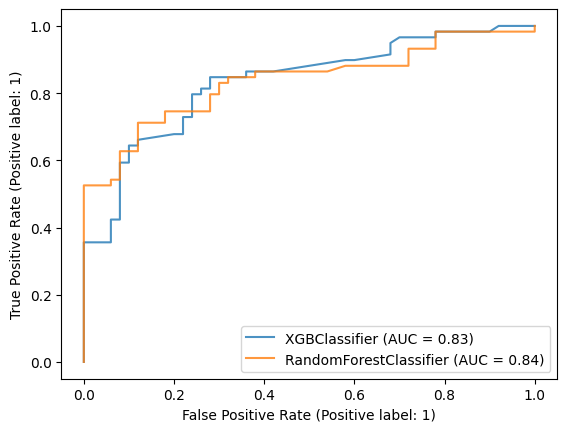

XGBoost results:
[06:42:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7706422018348624
 F1 score: 0.7899159663865546
 Test AUC: 0.7683050847457628
[0.7706422018348624, 0.7899159663865546, 0.7683050847457628]
Random forest results:
Accuracy: 0.7339449541284404
 F1 score: 0.7010309278350517
 Test AUC: 0.748135593220339
[0.7339449541284404, 0.7010309278350517, 0.748135593220339]


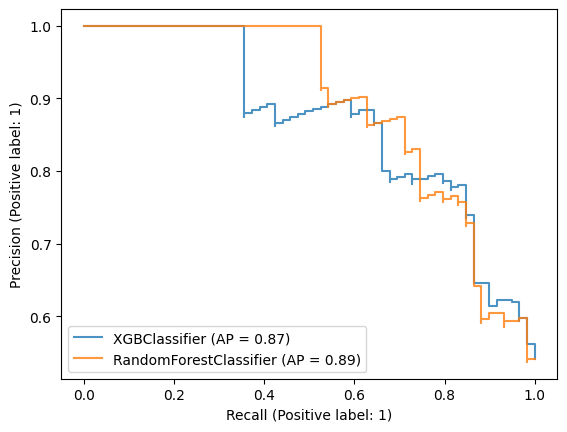

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.770642  0.789916        0.768305
Random forest  0.733945  0.701031        0.748136


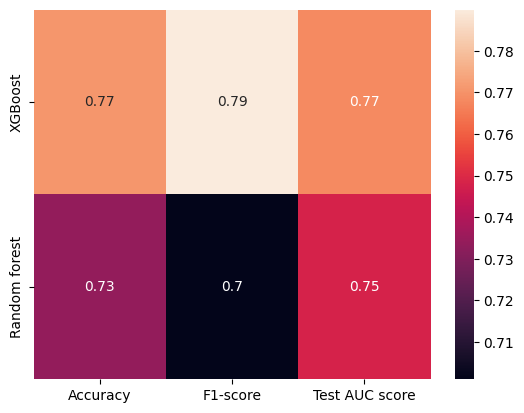

In [12]:
#ReactomeFI-SIGNOR
#ROC
X_train_ReactomeFI, X_test_SIGNOR, y_train_ReactomeFI, y_test_SIGNOR = prepare_data(drop_train=only_ReactomeFI, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                       y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#heatmap
params_df_ReactomeFI_SIGNOR = params_heatmap(params_xgb=params_xgb_ReactomeFI_SIGNOR, params_rfc=params_rfc_ReactomeFI_SIGNOR)

XGBoost results:
[06:42:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.46788990825688076
 F1 score: 0.6184210526315789
 Test AUC: 0.4383050847457627
[0.46788990825688076, 0.6184210526315789, 0.4383050847457627]
Random forest results:
Accuracy: 0.5779816513761468
 F1 score: 0.7160493827160493
 Test AUC: 0.5415254237288135
[0.5779816513761468, 0.7160493827160493, 0.5415254237288135]


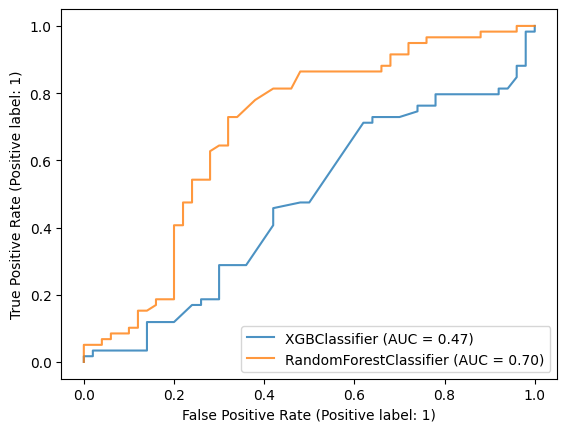

XGBoost results:
[06:42:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.46788990825688076
 F1 score: 0.6184210526315789
 Test AUC: 0.4383050847457627
[0.46788990825688076, 0.6184210526315789, 0.4383050847457627]
Random forest results:
Accuracy: 0.5779816513761468
 F1 score: 0.7160493827160493
 Test AUC: 0.5415254237288135
[0.5779816513761468, 0.7160493827160493, 0.5415254237288135]


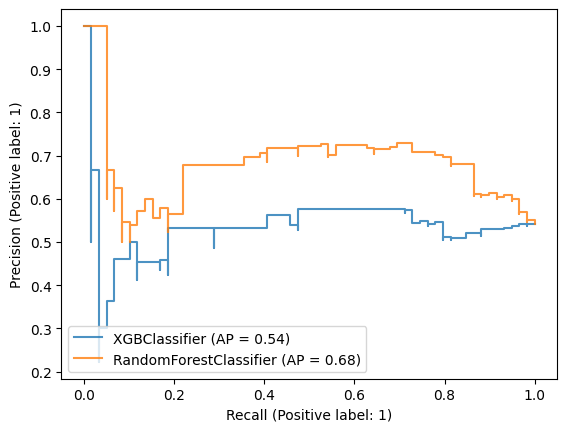

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.467890  0.618421        0.438305
Random forest  0.577982  0.716049        0.541525


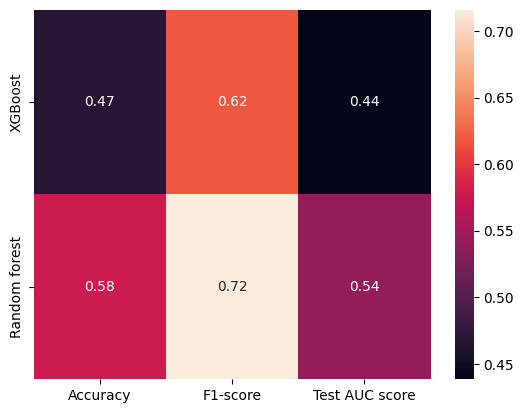

In [13]:
#CSN-ReactomeFI
#ROC
X_train_CSN, X_test_ReactomeFI, y_train_CSN, y_test_ReactomeFI = prepare_data(drop_train=only_CSN, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                       y_train_CSN, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#heatmap
params_df_CSN_ReactomeFI = params_heatmap(params_xgb=params_xgb_CSN_ReactomeFI, params_rfc=params_rfc_CSN_ReactomeFI)

XGBoost results:
[06:42:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6972477064220184
 F1 score: 0.6597938144329897
 Test AUC: 0.7111864406779661
[0.6972477064220184, 0.6597938144329897, 0.7111864406779661]
Random forest results:
Accuracy: 0.5596330275229358
 F1 score: 0.3333333333333333
 Test AUC: 0.5916949152542372
[0.5596330275229358, 0.3333333333333333, 0.5916949152542372]


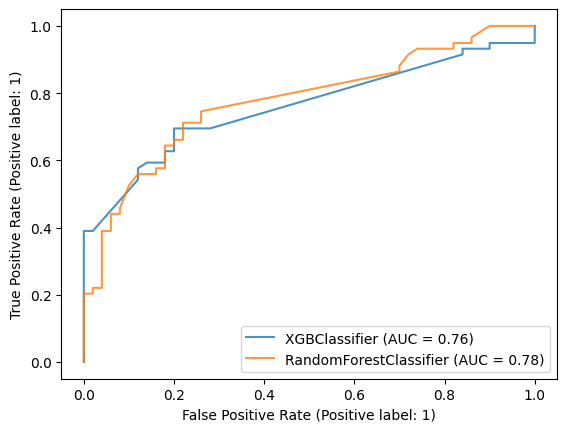

XGBoost results:
[06:43:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6972477064220184
 F1 score: 0.6597938144329897
 Test AUC: 0.7111864406779661
[0.6972477064220184, 0.6597938144329897, 0.7111864406779661]
Random forest results:
Accuracy: 0.5596330275229358
 F1 score: 0.3333333333333333
 Test AUC: 0.5916949152542372
[0.5596330275229358, 0.3333333333333333, 0.5916949152542372]


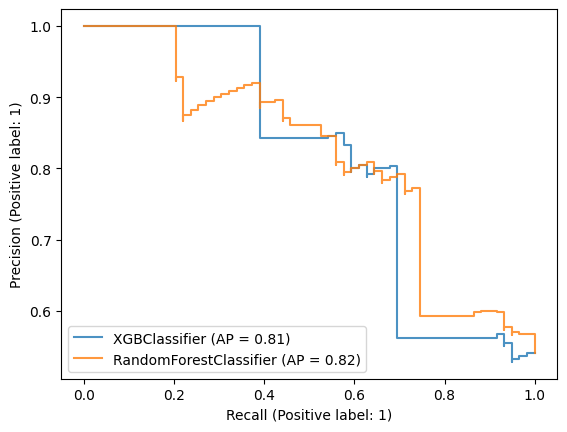

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.697248  0.659794        0.711186
Random forest  0.559633  0.333333        0.591695


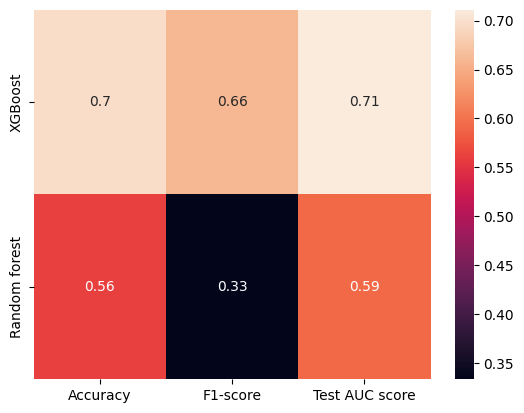

In [14]:
#ReactomeFI_CSN
#ROC
X_train_ReactomeFI, X_test_CSN, y_train_ReactomeFI, y_test_CSN = prepare_data(drop_train=only_ReactomeFI, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                       y_train_ReactomeFI, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#heatmap
params_df_ReactomeFI_CSN = params_heatmap(params_xgb=params_xgb_ReactomeFI_CSN, params_rfc=params_rfc_ReactomeFI_CSN)

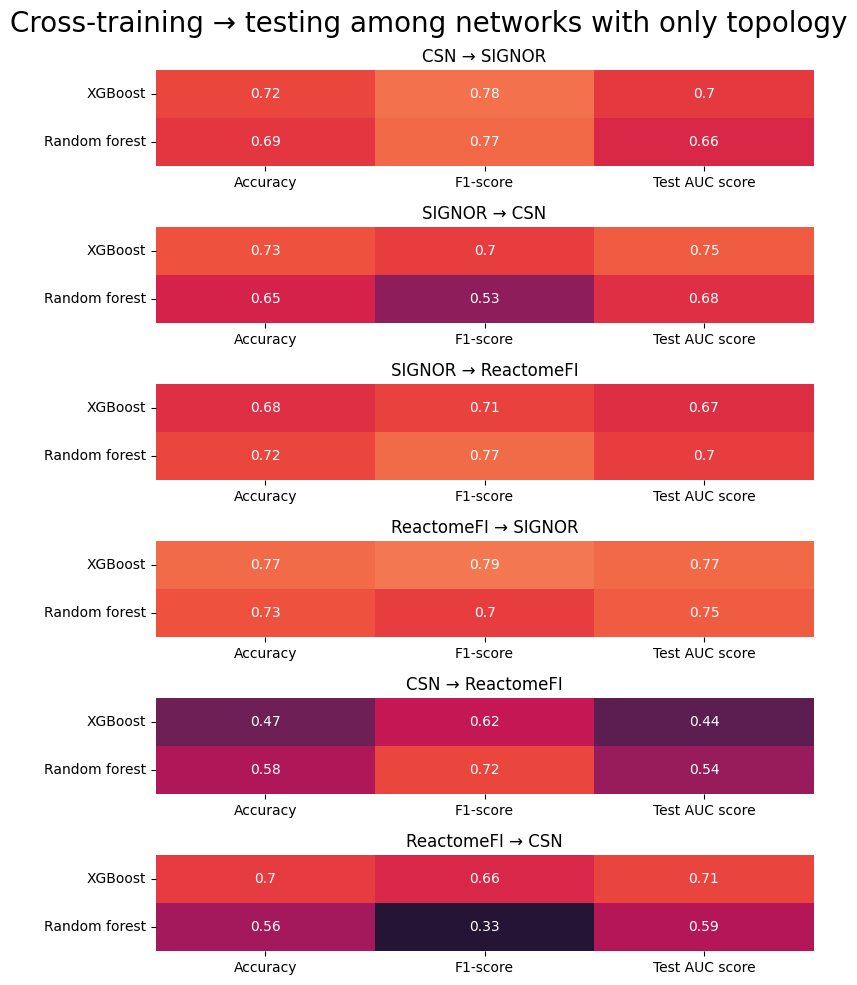

In [15]:
plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharey=False)
fig.subplots_adjust(wspace=0.02)

vmin = 0.26
vmax = 1

plt.suptitle("Cross-training → testing among networks with only topology", fontsize=20)

sns.heatmap(params_df_CSN_SIGNOR, annot=True, ax=ax1, cbar=False, vmin=vmin, vmax=vmax)
ax1.set_title('CSN → SIGNOR')
sns.heatmap(params_df_SIGNOR_CSN, annot=True, ax=ax2, cbar=False, vmin=vmin, vmax=vmax)
ax2.set_title('SIGNOR → CSN')
sns.heatmap(params_df_SIGNOR_ReactomeFI, annot=True, ax=ax3, cbar=False, vmin=vmin, vmax=vmax)
ax3.set_title('SIGNOR → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_SIGNOR, annot=True, ax=ax4, cbar=False, vmin=vmin, vmax=vmax)
ax4.set_title('ReactomeFI → SIGNOR')
sns.heatmap(params_df_CSN_ReactomeFI, annot=True, ax=ax5, cbar=False, vmin=vmin, vmax=vmax)
ax5.set_title('CSN → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_CSN, annot=True, ax=ax6, cbar=False, vmin=vmin, vmax=vmax)
ax6.set_title('ReactomeFI → CSN')

plt.show()